# 🤖 3 Training the forecasting model

### 🎯 Objective
The objective of this notebook is to include the needed code to train a forecasting model with the tools you find more suitable for the exercise.
You'll be guided through the notebook, but feel free to add anything you may find interesting to add value to the trained model and its accuracy.

### 🔙 Prerrequisites
1. Make sure you have built and transformed the dataset in previous steps, you'll find notebooks guiding you through this process in this same repository.
2. Install any dependencies you may need, using any dependency manager you like.

### 🏁 When you finish
Make sure to comment with markdown cells what you have developed to solve this problem. Also, try to explain how to use your code, what we need to install to use it, etc.

## 1. 🔍 Data Loading

Use this part of the notebook to work on: loading the built dataset and splitting in train, validation and test partitions if desired.

### 1.1 💾 Load the dataset.csv file you built in previous steps

In [85]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.arima.model import ARIMA
#from fbprophet import Prophet
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [64]:
sales_df = pd.read_csv('../data/Sales_ipc_calendar_dataset.csv')
sales_df.head()

,DATE,SALES,CUMULATIVE_SALES_ALL,HOLIDAY,Year,Month,DayOfWeek,YearMonth,IPC_VALUE,A,FA,FM,C,CR
0,2015-01-01,1.103868e+03,1.103868e+03,False,2015,1,3,2015-01,-0.4,0,0,0,1521,0
1,2015-01-02,1.317074e+07,1.317184e+07,False,2015,1,4,2015-01,-0.4,1508,0,0,13,0
2,2015-01-03,1.616656e+07,2.933840e+07,False,2015,1,5,2015-01,-0.4,1521,0,0,0,0
3,2015-01-04,1.267257e+05,2.946512e+07,False,2015,1,6,2015-01,-0.4,0,10,0,1511,0
4,2015-01-05,1.791498e+07,4.738010e+07,False,2015,1,0,2015-01,-0.4,1520,0,0,1,0


In [65]:
#missing_data = sales_df.isnull().sum()
#print("Missing values per column:\n", missing_data)
sales_df['HOLIDAY'] = sales_df['HOLIDAY'].astype(bool)
#print(sales_df.dtypes)

### 1.2 ✂️ Split your data in partitions

In [66]:
# Target (y) and Featurews(X)
X = sales_df.drop(columns=['SALES'])
y = sales_df['SALES']

To implement time series splitting for our forecasting model, it is important to split the data in a way that respects the temporal order, ensuring that future data is never used to train the model. One method commonly used for this is `TimeSeriesSplit` from scikit-learn, which ensures that each split contains past data and leaves future data for testing.

In [67]:
# Set up time series split (e.g., with 5 splits)
tscv = TimeSeriesSplit(n_splits=5)

Each iteration of the split will provide a larger portion of the past data for training and reserve a portion of the future data for validation.

For each split, we can train our model on the training set and validate it on the validation set.

In [68]:
# Visualize or print the indices of the train/test splits
for train_index, test_index in tscv.split(X):
    #print("\n \n \n TRAIN:", train_index, "\n \nTEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

## 2. 🎯 Feature Selection

Here, you may find useful to select the features you will use for training and the target to forecast. Try to explain why you have selected these features and discarded others.

Remember that the sales column you can find in `data/sales_train_dataset.csv` should be the target variable for your model.

**Correlation study**

By calculating the correlations between each variable and `SALES`, we can see which features have the strongest linear relationship with the target.

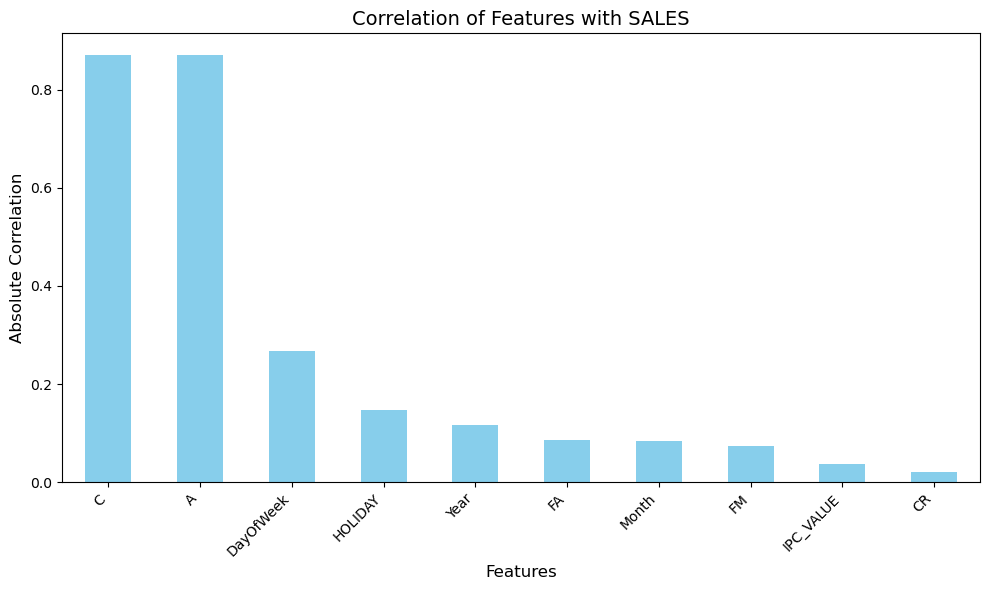

In [69]:
numeric_features = ['HOLIDAY', 'Year', 'Month', 'DayOfWeek', 'IPC_VALUE', 'A', 'FA', 'FM', 'C', 'CR']
correlation_matrix = sales_df[numeric_features + ['SALES']].corr()
correlation_with_sales = correlation_matrix['SALES'].drop('SALES')
correlation_with_sales_sorted = correlation_with_sales.abs().sort_values(ascending=False)
#print(correlation_with_sales_sorted)

plt.figure(figsize=(10, 6))
correlation_with_sales_sorted.plot(kind='bar', color='skyblue')
plt.title('Correlation of Features with SALES', fontsize=14)
plt.xlabel('Features', fontsize=12)

plt.ylabel('Absolute Correlation', fontsize=12)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

| Rank | Feature     | Correlation |
|------|-------------|-------------|
| 1    | C           | 0.871395    |
| 2    | A           | 0.870674    |
| 3    | DayOfWeek   | 0.267554    |
| 4    | HOLIDAY     | 0.147047    |
| 5    | Year        | 0.116122    |
| 6    | FA          | 0.086449    |
| 7    | Month       | 0.082997    |
| 8    | FM          | 0.073669    |
| 9    | IPC_VALUE   | 0.037194    |
| 10   | CR          | 0.019965    |


It is logical that the number of open or closed stores ranks highest in importance, as it directly impacts whether customers can make purchases. The day of the week also plays a significant role, with Saturdays showing a marked increase in sales compared to other days.

Now it would be necessary to study the autocorrelations since they can provide redundant information to the model, and in many cases, one of them can be removed without significantly affecting model performance. This process helps reduce model complexity and avoid multicollinearity issues, which can cause unstable or less interpretable models.

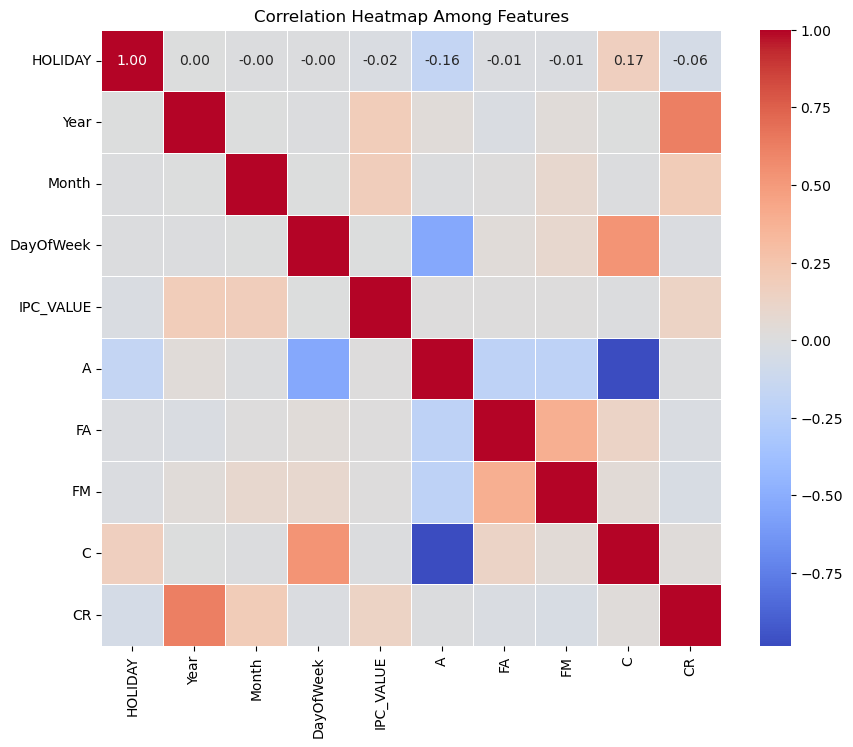

In [70]:
correlation_matrix = sales_df[numeric_features].corr()

# Plot a heatmap of the correlation matrix with numbers in all cells
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5, annot_kws={"size": 10})
plt.title('Correlation Heatmap Among Features')
plt.show()

# Identify highly correlated pairs (absolute value > 0.8)
highly_correlated = correlation_matrix.abs() > 0.8
highly_correlated_pairs = correlation_matrix[highly_correlated & (correlation_matrix != 1)]

#print("Highly Correlated Pairs:")
#print(highly_correlated_pairs)

As anticipated, the heatmap reveals a strong negative correlation between `A` (open stores) and `C` (closed stores), which makes sense given that these features represent mutually exclusive states. 

When a feature is constant or exhibits minimal variance, its correlation with other features will often result in `NaN` values. This occurs because correlation is undefined for variables with zero or near-zero variance. This is likely the cause of the `NaN` values observed when examining the `highly_correlated_pairs`, as some features may have little or no variability in the dataset. Addressing these features, such as by removing or transforming them, could resolve the issue.

Removing `CR` and `FM` because of its low relevance.

Removing `C`because of its high correlation with `A`.

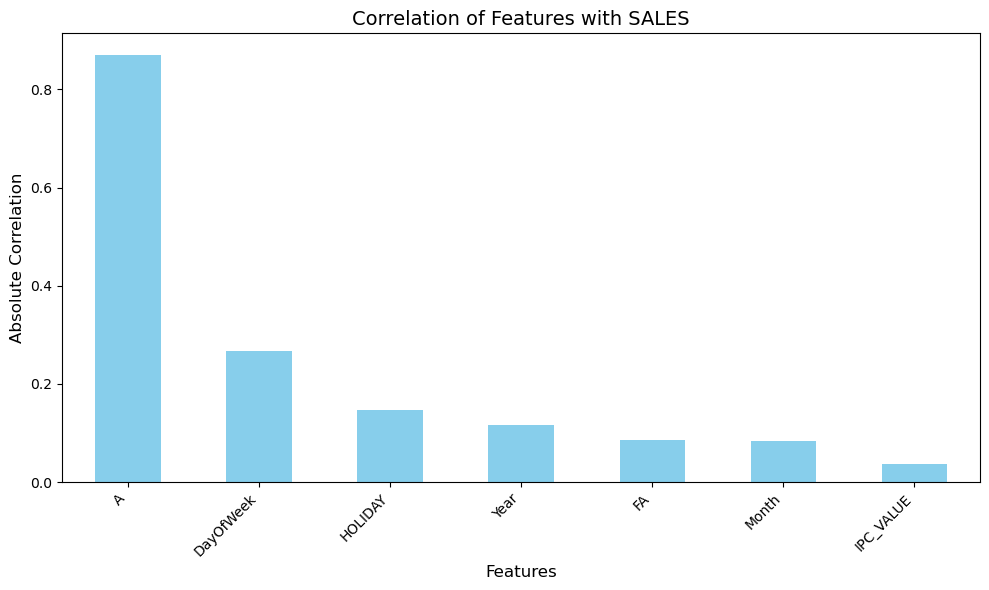

In [71]:
numeric_features = ['HOLIDAY', 'Year', 'Month', 'DayOfWeek', 'IPC_VALUE', 'A', 'FA']
correlation_matrix = sales_df[numeric_features + ['SALES']].corr()
correlation_with_sales = correlation_matrix['SALES'].drop('SALES')
correlation_with_sales_sorted = correlation_with_sales.abs().sort_values(ascending=False)
#print(correlation_with_sales_sorted)

plt.figure(figsize=(10, 6))
correlation_with_sales_sorted.plot(kind='bar', color='skyblue')
plt.title('Correlation of Features with SALES', fontsize=14)
plt.xlabel('Features', fontsize=12)

plt.ylabel('Absolute Correlation', fontsize=12)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

<!--
The [autocorrelation_plot](https://pandas.pydata.org/docs/reference/api/pandas.plotting.autocorrelation_plot.html) is a commonly used tool for checking randomness in a data set. This randomness is ascertained by computing autocorrelation for data values at varying time lags. 


#autocorrelation_plot(sales_df['SALES'])
#plt.show()

-->

### Other ideas

#### Lagged features

Let's explore adding lagged sales features, as these as they often carry strong predictive power for future sales in time series forecasting.

In [72]:
# Create lagged sales features
sales_lag_df = sales_df.copy()

sales_lag_df['lag_1'] = sales_lag_df['SALES'].shift(1)   # Lag by 1 day
sales_lag_df['lag_7'] = sales_lag_df['SALES'].shift(7)   # Lag by 7 days (1 week)

sales_lag_df = sales_lag_df.dropna()

#sales_lag_df[['SALES', 'lag_1', 'lag_7']].head(14)

#### Deterring

Detrending removes the long-term growth or decline in the data. This is important because it helps isolate the patterns that are independent of the long-term upward or downward trend.

see [Time Series Feature Selection: Which Methods to Apply](https://medium.com/@saverio3107/time-series-feature-selection-which-methods-to-apply-ec2b6aa57bef)

<!--
```
# Detrend by differencing
sales_lag_df['sales_detrended'] = sales_lag_df['SALES'].diff()

# Drop the first NaN value caused by differencing
sales_lag_df.dropna(inplace=True)

# Verify the detrended sales
print(sales_lag_df[['SALES', 'sales_detrended']].head())
```

Note: Turned off by now
-->

In [73]:
# Detrend by differencing
sales_lag_df['sales_detrended'] = sales_lag_df['SALES'].diff()

# Drop the first NaN value caused by differencing
sales_lag_df.dropna(inplace=True)

# Verify the detrended sales
print(sales_lag_df[['SALES', 'sales_detrended']].head())

           SALES  sales_detrended
8   1.442774e+07     2.070327e+06
9   1.830662e+07     3.878875e+06
10  7.223293e+04    -1.823438e+07
11  1.238362e+07     1.231138e+07
12  1.075283e+07    -1.630791e+06


<!--
#### Deseasonalizing

Deseasonalizing removes the seasonal patterns (e.g., weekly, monthly) from the data. This allows the model to focus on underlying trends and avoid overfitting to seasonal fluctuations.

```
sales_lag_df['DATE'] = pd.to_datetime(sales_lag_df['DATE'])

# Set the DATE column as the index and fill missing dates with daily frequency
sales_lag_df = sales_lag_df.set_index('DATE').asfreq('D')  # 'D' stands for daily frequency

# Apply STL decomposition with an appropriate seasonal period (e.g., 7 for weekly seasonality)
stl = STL(sales_lag_df['SALES'], seasonal=7)
result = stl.fit()

# Deseasonalized sales
sales_lag_df['sales_deseasonalized'] = sales_lag_df['SALES'] - result.seasonal

# Verify the deseasonalized sales
print(sales_lag_df[['SALES', 'sales_deseasonalized']].head())
```
-->

In [74]:
#sales_lag_df.head()

#### RandomForestRegressor for Feature Selection

Although `RandomForestRegressor` is not designed for time series forecasting, it is highly effective for feature selection. It ranks features by importance, helping determine how much each contributes to the prediction task. 
<!--
This method is valuable because it:

- **Captures nonlinear relationships** between features and the target variable.
- **Accounts for feature interactions**, which might be missed by simpler statistical methods.
- **Does not require stationarity**, unlike traditional time series models like ARIMA.
-->
By using `RandomForest`, we can rank both time-based features (e.g., lagged features) and categorical variables (e.g., `DayOfWeek`). The most relevant features can then be used in time-series-specific models like ARIMA, Prophet, or LSTM for better forecasting performance.

In [75]:
features = ['HOLIDAY', 'Year', 'Month', 'DayOfWeek', 
            'IPC_VALUE', 'A', 'FA','lag_1', 'lag_7']
            #,'FM', 'C', 'CR']
            #'sales_deseasonalized', 'sales_detrended']  # left out 

X = sales_lag_df[features]
y = sales_lag_df['SALES']

# Train Random Forest
rf_model = RandomForestRegressor()
rf_model.fit(X, y)

# Display feature importance
feature_importance = pd.Series(rf_model.feature_importances_, index=features)
#feature_importance.sort_values(ascending=False)

| Feature    | Importance Value  |
|------------|-------------------|
| A          | 0.7593            |
| DayOfWeek  | 0.1194            |
| lag_7      | 0.0534            |
| lag_1      | 0.0434            |
| FA         | 0.0107            |
| Month      | 0.0075            |
| Year       | 0.0036            |
| IPC_VALUE  | 0.0028            |
| HOLIDAY    | 0.0000000212      |

<!--
1. **A (Open)**:
   - Being the most important feature, this suggests that whether the store is open or closed has the strongest influence on sales.
   
2. **DayOfWeek**:
   - Sales behavior changes by the day of the week, as previously analyzed, with Saturdays generally showing the highest sales.

3. **Lag Features (lag_7 and lag_1)**:
   - These show that past sales data from one week ago (`lag_7`) and one day ago (`lag_1`) provide relevant information for forecasting sales. This is common in time series data, where historical values have predictive power.

4. **FA (Open on holiday)**:
   - This shows that being open on a holiday provides a minor contribution to predicting sales. It is less important than general open/closed status.

5. **Month and Year**:
   - These capture broader seasonality and year-over-year trends, but their impact is minimal compared to the other features.

6. **IPC_VALUE (Inflation)**:
   - The inflation value (`IPC_VALUE`) has some predictive power but is not very significant in daily sales predictions.

7. **HOLIDAY**:
   - This feature has almost no influence on predicting sales, potentially because other variables (such as `FA` and `A`) already capture the holiday effects.
-->

`RandomForestRegressor` effectively ranked the features by importance, identifying key predictors such as store open status (`A`), day of the week, and lagged sales data. These features are critical in forecasting sales.

The final set of features is:

In [76]:
features = ['A'
            , 'DayOfWeek'
            , 'lag_1'
            , 'lag_7'
            , 'FA'
            , 'Month'
            , 'Year'
           ] 

## 3. 🤖 Modeling

In this section you will declare everything you need to train your model and fit it to your dataset.

When using cross-validation (like `TimeSeriesSplit`),it is not necessary a separate validation set, since each fold in cross-validation acts as both validation and training at different stages.

However, we could manually split the time data doing the following:
```
train_size = int(len(sales_lag_df) * 0.7)        # 70% training
validation_size = int(len(sales_lag_df) * 0.15)  # 15% validation
test_size = len(sales_lag_df) - train_size - validation_size  # 15% test

train_df = sales_lag_df.iloc[:train_size]
validation_df = sales_lag_df.iloc[train_size:train_size + validation_size]
test_df = sales_lag_df.iloc[train_size + validation_size:]

X_train, y_train = train_df.drop(columns=['SALES']), train_df['SALES']
X_val, y_val = validation_df.drop(columns=['SALES']), validation_df['SALES']
X_test, y_test = test_df.drop(columns=['SALES']), test_df['SALES']
```
Note that for time series data, we don't want to randomize the splits because preserving the temporal order is crucial.


We will stick to cross-validation

### 3.1 Prophet
Simple model for forecasting

```
prophet_df = sales_lag_df[['DATE', 'SALES']].rename(columns={'DATE': 'ds', 'SALES': 'y'})
model = Prophet()
model.fit(prophet_df)
future = model.make_future_dataframe(periods=30)  # Forecast 30 days ahead
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
```


### 3.2 ARIMA (AutoRegressive Integrated Moving Average)
Statistical model that captures the dependencies in time series data. A priori, this can be the best choice since it works well for univariate forecasting tasks (like predicting `SALES` over time).

**ADF**

The Augmented Dickey-Fuller (ADF) test is used to check whether a time series is stationary or not. Stationarity is an important assumption for many time series models, including ARIMA. If the p-value of the ADF test is below a certain threshold (e.g., 0.05), you can reject the null hypothesis that the series has a unit root, indicating that the series is stationary.

In [77]:
def perform_adfuller_test(series, column_name):

    result = adfuller(series)

    print(f"ADF Test for {column_name}:")
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')
    
    # Interpret the p-value
    if result[1] < 0.05:
        print(f"The {column_name} series is stationary (reject the null hypothesis).\n")
    else:
        print(f"The {column_name} series is not stationary (fail to reject the null hypothesis).\n")

In [78]:
perform_adfuller_test(sales_lag_df['SALES'], 'SALES')

ADF Test for SALES:
ADF Statistic: -2.5503603584929713
p-value: 0.10369679262560683
Critical Values:
   1%: -3.4349343845870006
   5%: -2.8635646903561653
   10%: -2.5678479326174157
The SALES series is not stationary (fail to reject the null hypothesis).



This is relevant since ARIMA assumes the data is stationary. 

By using `sales_detrended`instead of `SALES`, we have stationary data. This means that we can proceed using ARIMA model without further tranformations to make data stationary.

In [79]:
perform_adfuller_test(sales_lag_df['sales_detrended'], 'sales_detrended')

ADF Test for sales_detrended:
ADF Statistic: -15.490282571499169
p-value: 2.4900079227518523e-28
Critical Values:
   1%: -3.434931172941245
   5%: -2.8635632730206857
   10%: -2.567847177857108
The sales_detrended series is stationary (reject the null hypothesis).



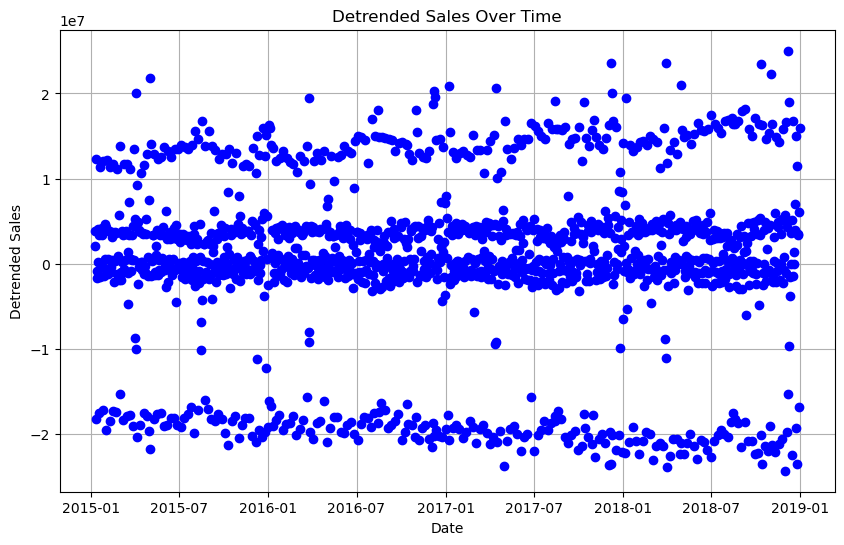

In [81]:
sales_lag_dff = sales_lag_df.copy()
sales_lag_dff['DATE'] = pd.to_datetime(sales_lag_dff['DATE'])
sales_lag_dff.set_index('DATE', inplace=True)

# Plot sales_detrended vs date
plt.figure(figsize=(10, 6))
plt.plot(sales_lag_dff.index, sales_lag_dff['sales_detrended'], color='blue',linestyle='None', marker='o')
plt.title('Detrended Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Detrended Sales')
plt.grid(True)
plt.show()

Differencing has already been applied to `sales_detrended`, so we use this detrended data for the ARIMA model instead of `SALES`

Applying `TimeSeriesSplit`for Cross-Validation

In [83]:
print(f"Features: {features}")

sales_lag_df['DATE'] = pd.to_datetime(sales_lag_df['DATE'], errors='coerce')
sales_lag_df.set_index('DATE', inplace=True)
sales_lag_df = sales_lag_df.asfreq('D')

X = sales_lag_df[features] 
#y = sales_lag_df['SALES']
y = sales_lag_df['sales_detrended']  # differentitated target


tscv = TimeSeriesSplit(n_splits=5)

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    print(f"\nX_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
    print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

Features: ['A', 'DayOfWeek', 'lag_1', 'lag_7', 'FA', 'Month', 'Year']

X_train shape: (243, 7), X_test shape: (242, 7)
y_train shape: (243,), y_test shape: (242,)

X_train shape: (485, 7), X_test shape: (242, 7)
y_train shape: (485,), y_test shape: (242,)

X_train shape: (727, 7), X_test shape: (242, 7)
y_train shape: (727,), y_test shape: (242,)

X_train shape: (969, 7), X_test shape: (242, 7)
y_train shape: (969,), y_test shape: (242,)

X_train shape: (1211, 7), X_test shape: (242, 7)
y_train shape: (1211,), y_test shape: (242,)


We can build an ARIMA model on each training set and evaluate its performance on the corresponding test set.

It is necessary to choose the $d$, $p$ and $q$ for the ARIMA model. This model combines Auto Regression(AR), Moving Average(MA) and differencing(I). Equations below show the meaning of $p$ and $q$.


- Autoregression AR($p$): $y_t = \alpha + \beta_1 y_{t-1} + \beta_2 y_{t-2} + \beta_3 y_{t-3} + \dots + \beta_{p} y_{t-p}$

- Moving average MA($q$): $y_t = \mu + \epsilon_{t} + \omega_{1} \epsilon_{t-1} + \omega_{2} \epsilon_{t-2} + \omega_{3} \epsilon_{t-3} + \dots + \omega_{q} \epsilon_{t-q}$

- ARMA($p,q$): $y_t = \alpha + \epsilon_{t} + \sum_{i=1}^{p} \beta_i y_{t-i} + \sum_{j=1}^{q} \omega_j \epsilon_{t-j}$


Since we have differenciated our data once, we can set `d=0`.

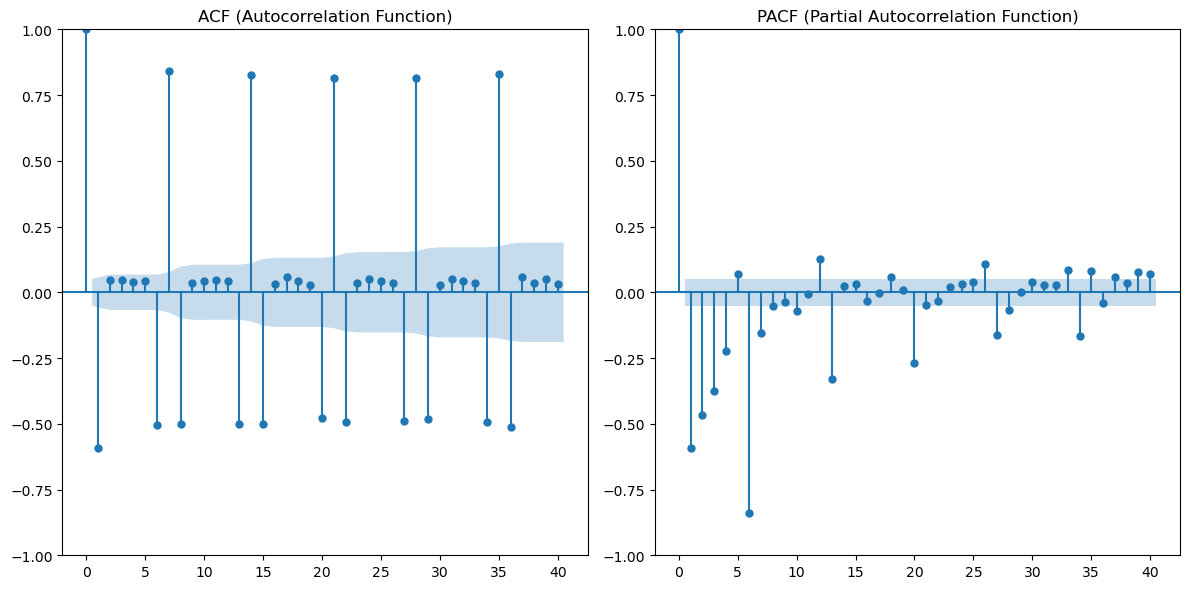

In [86]:
plt.figure(figsize=(12, 6))

# Plot ACF (for choosing q)
plt.subplot(121)
plot_acf(sales_lag_df['sales_detrended'], lags=40, ax=plt.gca())
plt.title('ACF (Autocorrelation Function)')

# Plot PACF (for choosing p)
plt.subplot(122)
plot_pacf(sales_lag_df['sales_detrended'], lags=40, ax=plt.gca())
plt.title('PACF (Partial Autocorrelation Function)')

plt.tight_layout()
plt.show()

In [84]:
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    #print(f"\nX_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
    #print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")
    
    # Train ARIMA model on y_train (you can add order based on your analysis)
    
    p = 7 # number of autoregressive terms
    d = 0 # number of nonseasonal differences needed for stationarity (for the AR)
    q = 1 # number of lagged forecast errors in the prediction equation (for the MA)
    
    model = ARIMA(y_train, order=(p, q, d))   
    model_fit = model.fit()

    # Predict on the test set (detrended predictions)
    y_pred_detrended = model_fit.forecast(steps=len(y_test))  # Forecasting the length of the test set

    # To convert back to original SALES
    last_original_value = sales_lag_df['SALES'].iloc[train_index[-1]]
    
    # Reintegrate predictions: cumulative sum of predicted differences + last known sales value
    y_pred_sales = np.r_[last_original_value, y_pred_detrended].cumsum()[1:]  # Start from the next value
    
    mse = mean_squared_error(sales_lag_df['SALES'].iloc[test_index], y_pred_sales)
    print(f"Mean Squared Error on this fold: {mse}")

    
    print("Predicted Sales (reconstructed):", y_pred_sales)
    print("Actual Sales:", sales_lag_df['SALES'].iloc[test_index].values)

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next v

Mean Squared Error on this fold: 6468113082446251.0
Predicted Sales (reconstructed): [ 9.07994719e+06  8.26886930e+06  1.01015070e+07  1.32242196e+07
 -2.98678443e+06  9.95862995e+06  6.68342485e+06  4.92607942e+06
  4.41082915e+06  5.53674264e+06  8.49331919e+06 -6.01346837e+06
  5.98328575e+06  3.34288590e+06  6.90339648e+05  4.82681196e+05
  1.15649773e+06  3.95569579e+06 -9.03636589e+06  1.95761686e+06
 -2.06451781e+05 -3.57479262e+06 -3.46106786e+06 -3.06689391e+06
 -4.44396262e+05 -1.21044416e+07 -2.12297526e+06 -3.91537209e+06
 -7.82619202e+06 -7.39431674e+06 -7.16557643e+06 -4.75298679e+06
 -1.52448024e+07 -6.25079920e+06 -7.73958861e+06 -1.20371197e+07
 -1.13069368e+07 -1.11722305e+07 -9.00425720e+06 -1.84689635e+07
 -1.04121651e+07 -1.16426135e+07 -1.61939512e+07 -1.51986408e+07
 -1.51161759e+07 -1.32215872e+07 -2.17778609e+07 -1.45919243e+07
 -1.55963828e+07 -2.02927287e+07 -1.90743275e+07 -1.90215104e+07
 -1.74194658e+07 -2.51659928e+07 -1.87762235e+07 -1.95806474e+07
 -2.4

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473

Mean Squared Error on this fold: 1632738784113077.2
Predicted Sales (reconstructed): [ 12964621.63941098  18921342.66849684  14974864.42766168
  -1032329.97485382   7459841.28148755  13274628.02051364
  12395379.44559001  10306258.75548797  14758225.96419608
  11561803.8689526   -1784617.87652693   6901176.62734209
  12519336.76475709  10288410.57527891   7517673.92136119
  11115854.45588548   8757244.17996741  -2358367.55230631
   6084041.58164858  11205087.9725397    7867846.54203483
   4776030.30206769   7954319.5161184    6393262.17219925
  -2926969.38231704   4969404.63346931   9455134.81740155
   5299148.96510544   2174159.7509599    5203918.97985108
   4317660.46014245  -3601524.69650631   3565972.48590578
   7393172.12942505   2702779.46028733   -248370.04540483
   2778669.33251039   2407004.58470974  -4443635.76360449
   1911875.10965554   5129639.40400756    158130.07780564
  -2489085.93010762    591471.40666953    568873.38770396
  -5477142.38532        59250.41448099   2755

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473

Mean Squared Error on this fold: 92312787294140.11
Predicted Sales (reconstructed): [17260090.68979296 14935423.17626494 13602994.65948341 13817091.53326184
 16001579.38469486 19462686.57977467  1934977.9835283  17617010.38917923
 16242245.34251331 13672906.61020245 13916297.48533312 15558647.48022648
 18916792.795483    3767165.86478981 17928678.18829921 17165187.20702656
 13647242.61855531 14004751.09664495 15390329.14661236 18641614.8842359
  5508999.5771353  18153204.30525203 17799784.64355507 13604713.73815741
 14141261.78000166 15444687.08652605 18548180.71965061  7108831.17826293
 18293040.32955379 18228496.95114112 13601022.5836275  14349115.2861372
 15665366.37374673 18566355.85462378  8544849.98746908 18366561.43093289
 18521861.99758247 13667754.69532263 14629966.6646718  15999070.35779563
 18645847.00778631  9816221.2964612  18398646.52900631 18735426.12563307
 13817577.37478334 14973081.07856851 16400550.54624681 18753921.61689792
 10935450.1016655  18414243.08093783 18909

Mean Squared Error on this fold: 473480921177159.7
Predicted Sales (reconstructed): [16794382.95404129 20610366.59832438  1518704.87519943 20968975.57629545
  4687607.93443893 16921969.17030002 17389120.09476699 15982226.69884882
 19686103.96626439  3595835.73320777 21437054.17480364  8598337.60222651
 17687518.39988554 18508129.9715014  15567772.61001277 19374637.81058878
  6041479.91154576 22086205.62655144 11785722.30853503 18160350.55817701
 19307201.94106884 15598825.67340907 19552465.7832227   8606856.26557308
 22752752.23747247 14350364.0198751  18508982.78202428 19996790.09895625
 16043251.16925938 20077324.13343519 11121506.38949947 23364578.22617038
 16424882.59271563 18862120.71045177 20697662.14570595 16824444.40137096
 20821208.32250747 13485008.22759062 23909220.5133843  18141780.84718106
 19303225.2534571  21465293.65884415 17851201.10301702 21684421.63922369
 15652416.65672526 24406691.07395462 19615610.8552292  19874984.08782836
 22312991.14095211 19036916.62639642 225

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


After making predictions on the detrended data, we can convert them back to the original `SALES`by reversing the differencing process. The key idea is to re-integrate the predicted differences (detrended values) back to the original scale by adding the last actual value from the previous data point.

### 3.3 LSTM (Long Short-Term Memory Neural Networks)

Implement this type of RNN for time series forescasting. 

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(sales_lag_df['SALES'].values.reshape(-1, 1))

# Prepare training data with a sequence of 60 days (or any other window size)
X_train, y_train = [], []
for i in range(60, len(scaled_data)):
    X_train.append(scaled_data[i-60:i, 0])
    y_train.append(scaled_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape for LSTM input
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

# Compile and fit the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=1, epochs=10)

NameError: name 'MinMaxScaler' is not defined

## 4. ✅ Validation

Decide what metric to use to validate the performance of your model and explain why you chose it.

## 5. 📊 Presentation of Results

If you find it interesting, you can use plots to explain your results, metrics and how your model performance degrades over time.

Also, it may be interesting to write down future work that you think may improve the obtained result.

### 5.1 👨🏻‍🏫 Explainability with SHAP

You have explained the results of your trained model using plots and your own words. Now... let's take the next step. We'll be using a library called SHAP, that may help you find insights and explainability on how your model learned the data.

If you haven't heard of SHAP you can find their web site here:

https://shap.readthedocs.io/en/latest/

Don't worry, you will be guided through this exercises.

#### 5.1.1 🐝 Build a Beeswarm plot

Build a Beeswarm plot to help you explain how each feature affects to the output given by the model

#### 5.1.2 💪🏻 Build a Force plot

Build a Force plot to help you explain how each feature affects to the output given by the model

#### 5.1.3 🤷🏻‍♂️ Optional

Explore the SHAP documentation and add any plot you may find useful to explain how the model decides its outputs.

## 6. 🗃️ Model export

If you have arrived to this point... Congratulations!! 🥳. You trained a working model that can now be served in an API to be used to make predictions.

If you feel like developing a simple REST API to serve your amazing model, continue to the next step you will find in the `app/main.py` file located in this repository.

But first, make sure to export your model to a file you can use to load it in your endpoint.